In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset="train", categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset="test", categories=categories, remove=remove)

In [4]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [5]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [6]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [7]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'],
      dtype='<U18')

In [8]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [9]:
num_topics, num_top_words = 6, 8

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [11]:
vectorizer = CountVectorizer(stop_words="english")
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vectors.shape

(2034, 26576)

In [12]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [13]:
vocab = np.array(vectorizer.get_feature_names())

In [14]:
vocab.shape

(26576,)

In [15]:
vocab[7000: 7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel', 'counselees',
       'counselor', 'count'],
      dtype='<U80')

## SVD

SVD 将一个矩阵分解为正交基 U 和 V，一个对角矩阵

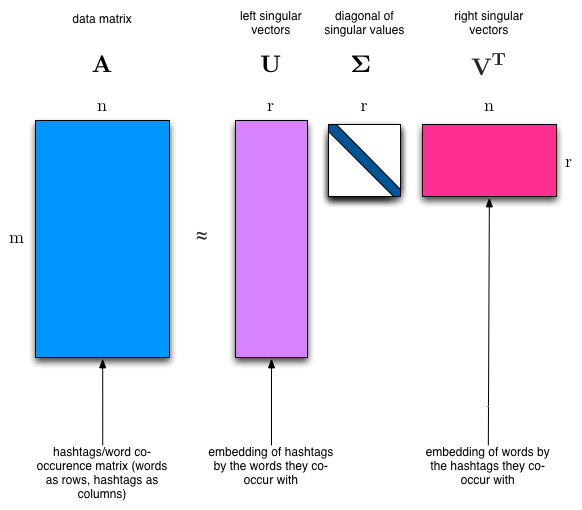

In [16]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 31.8 s, sys: 1.41 s, total: 33.2 s
Wall time: 18.7 s


In [17]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [18]:
print((U * s).dot(Vh).shape)

(2034, 26576)


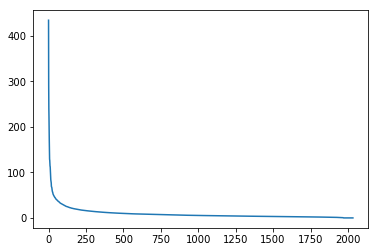

In [19]:
plt.plot(s)

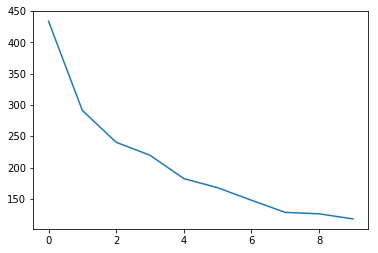

In [20]:
plt.plot(s[:10])

In [21]:
num_top_words = 8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words - 1: -1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [22]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

## NMF

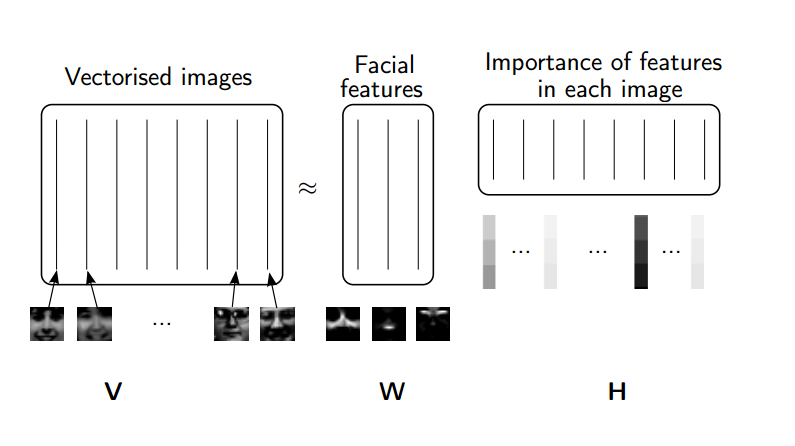

In [23]:
m, n = vectors.shape
d = 5

In [24]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [25]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [26]:
vectorizer_tfidf = TfidfVectorizer(stop_words="english")
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [27]:
vectors_tfidf

<2034x26576 sparse matrix of type '<class 'numpy.float64'>'
	with 133634 stored elements in Compressed Sparse Row format>

In [28]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [29]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

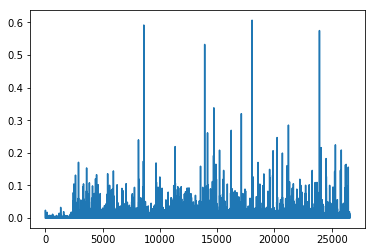

In [30]:
plt.plot(clf.components_[0])

In [31]:
clf.reconstruction_err_

43.712926057952757

### SGD to NMF

In [32]:
lam = 1e3
lr = 1e-2
m, n = vectors_tfidf.shape

In [33]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [34]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [35]:
def penalty(M, mu):
    return np.where(M >= mu, 0, np.min(M - mu, 0))

In [36]:
mu = 1e-6
def grads(M, W, H):
    R = W@H - M
    return R@H.T + penalty(W, mu) * lam, W.T@R + penalty(H, mu) * lam # dW, dH

In [37]:
def upd(M, W, H, lr):
    dW, dH = grads(M, W, H)
    W -= lr * dW
    H -= lr * dH

In [38]:
def report(M, W, H):
    print(np.linalg.norm(M - W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [39]:
W = np.abs(np.random.normal(scale=0.01, size=(m, d)))
H = np.abs(np.random.normal(scale=0.01, size=(d, n)))

In [40]:
report(vectors_tfidf, W, H)

44.4255542986 1.02195462392e-06 1.12593167545e-07 0 0


In [41]:
upd(vectors_tfidf, W, H, lr)

In [42]:
report(vectors_tfidf, W, H)

44.4178842627 -0.000778861447081 -6.94423710532e-05 140 298


In [43]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

44.4121642231 -0.000690228742741 -6.80788627246e-05 134 264
44.3746771383 -0.000281011422037 -4.53959780161e-05 53 529
44.3459653663 -0.000212308709335 -5.71188209023e-05 24 909
44.3139583101 -0.000170918081712 -9.24624164159e-05 25 1536
44.2788009435 -8.60900403023e-05 -0.000129389354002 32 2282


In [44]:
show_topics(H)

['god people don space just know think like',
 'people space don think know just like god',
 'god space don people just like think know',
 'god space people think don know just does',
 'don god just space people like know think']

## PyTorch

In [47]:
import torch
from torch.autograd import Variable

In [48]:
def V(M): return Variable(M, requires_grad=True)

In [49]:
v = vectors_tfidf.todense()

In [55]:
t_vectors = torch.Tensor(v.astype(np.float32))

In [56]:
mu = 1e-5

In [63]:
def grads_t(M, W, H):
    R = W.mm(H) - M
    return (R.mm(H.t()) + penalty_t(W, mu) * lam,
           W.t().mm(R) + penalty_t(H, mu) * lam)

def penalty_t(M, mu):
    return (M < mu).type(torch.FloatTensor) * torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW, dH = grads_t(M, W, H)
    W.sub_(lr * dW); H.sub_(lr * dH)

def report_t(M, W, H): 
    print((M - W.mm(H)).norm(2), W.min(), H.min(), (W < 0).sum(), (H < 0).sum())

In [64]:
t_W = torch.FloatTensor(m, d)
t_H = torch.FloatTensor(d, n)
t_W.normal_(std=0.01).abs_()
t_H.normal_(std=0.01).abs_()


 3.9487e-03  9.2725e-04  6.6077e-03  ...   7.1477e-03  4.8490e-03  1.4268e-02
 4.6919e-03  1.0102e-02  8.6038e-03  ...   1.9083e-04  4.5225e-03  1.0495e-02
 5.8093e-03  3.0922e-03  1.8158e-03  ...   8.3865e-03  7.1897e-03  9.3279e-04
 5.7938e-03  6.7347e-03  1.4845e-02  ...   3.8448e-04  3.9956e-03  1.3247e-03
 2.9476e-03  5.3264e-03  5.9448e-04  ...   1.4002e-02  9.5254e-03  5.6442e-04
 1.1506e-04  5.7038e-03  6.6996e-05  ...   1.6878e-02  3.2812e-03  1.7471e-02
[torch.FloatTensor of size 6x26576]

In [65]:
d = 6; lam = 100; lr = 0.05

In [66]:
for i in range(1000):
    upd_t(t_vectors, t_W, t_H, lr)
    if i % 100 == 0:
        report_t(t_vectors, t_W, t_H)
        lr *= 0.9

44.39260559661584 -0.006614388898015022 -0.0006283363327383995 1471 2292
43.73299515706816 -0.010432898066937923 -0.00818666722625494 1954 22996
43.68627766356948 -0.010306276381015778 -0.011132689192891121 2080 23027
43.66110054404283 -0.008442096412181854 -0.010793029330670834 2322 21520
43.65650360344355 -0.006459904834628105 -0.0036113138776272535 2474 21615
43.65498513158673 -0.005602513439953327 -0.007494053337723017 3022 23571
43.65469856033504 -0.005656036082655191 -0.004922118037939072 3168 24202
43.65438781601866 -0.0036335294134914875 -0.00558325182646513 3020 25553
43.65424050169668 -0.0042676073499023914 -0.005477633327245712 2894 25694
43.65394032528427 -0.004066063091158867 -0.00498313969001174 3791 33003


In [67]:
show_topics(t_H.cpu().numpy())

['ico bobbe tek bronx beauchaine manhattan sank queens',
 'thanks files image file program windows format know',
 'people don think just objective like say morality',
 'god jesus bible believe atheism christian belief does',
 'space nasa launch shuttle orbit moon lunar earth',
 'graphics comp group just aspects software 3d newsgroup']

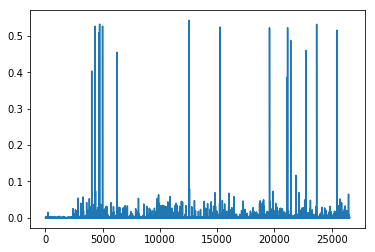

In [68]:
plt.plot(t_H.cpu().numpy()[0])

In [70]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]



In [71]:
print(x.data)


 1  1
 1  1
[torch.FloatTensor of size 2x2]



In [72]:
print(x.grad)

None


In [74]:
y = x + 2
print(y)

Variable containing:
 3  3
 3  3
[torch.FloatTensor of size 2x2]



In [75]:
z = y * y * 3
out = z.sum()
print(z, out)

Variable containing:
 27  27
 27  27
[torch.FloatTensor of size 2x2]
 Variable containing:
 108
[torch.FloatTensor of size 1]



In [76]:
out.backward()

In [78]:
x.grad

Variable containing:
 18  18
 18  18
[torch.FloatTensor of size 2x2]

In [79]:
lam = 1e6

In [80]:
pW = Variable(torch.FloatTensor(m,d), requires_grad=True)
pH = Variable(torch.FloatTensor(d,n), requires_grad=True)
pW.data.normal_(std=0.01).abs_()
pH.data.normal_(std=0.01).abs_();

In [81]:
def report():
    W, H = pW.data, pH.data
    print((M - pW.mm(pH)).norm(2).data[0], W.min(), H.min(), (W < 0).sum(), (H < 0).sum())

def penalty(A):
    return torch.pow((A<0).type(torch.FloatTensor) * torch.clamp(A, max=0.), 2)

def penalize(): return penalty(pW).mean() + penalty(pH).mean()

def loss(): return (M - pW.mm(pH)).norm(2) + penalize() * lam

In [82]:
M = Variable(t_vectors)

In [83]:
opt = torch.optim.Adam([pW,pH], lr=1e-3, betas=(0.9,0.9))
lr = 0.05
report()

44.43767166137695 5.606665354207507e-07 3.683480898075686e-08 0 0


In [84]:
for i in range(1000): 
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    if i % 100 == 99: 
        report()
        lr *= 0.9     # learning rate annealling

43.96528244018555 -0.0007501645013689995 -0.0014626247575506568 198 11961
43.79193115234375 -0.000909572234377265 -0.0008526461315341294 229 14036
43.729248046875 -0.0004507738340180367 -0.0009195529855787754 201 14231
43.694454193115234 -0.0003227060369681567 -0.0012054047547280788 192 14128
43.67707061767578 -0.0003769031900446862 -0.0012003573356196284 193 13123
43.66980743408203 -0.00025051413103938103 -0.0012245727702975273 200 12206
43.66585922241211 -0.00039634594577364624 -0.0014431084273383021 210 11342
43.66016387939453 -0.00028289310284890234 -0.001397597137838602 225 10878
43.65519714355469 -0.0002710175758693367 -0.0009572948911227286 278 10486
43.65267562866211 -0.0002708380634430796 -0.0007490452262572944 232 9800
